In [26]:
### Make CSV of CONUS2 flow at matched gages ###
### DTT, 05/23

# This script is split into two main parts: 1) reading in CONUS2 gridded total (aggregated) daily flow for the full domain and creating a dataframe of CONUS2 flow for cells that have been matched with USGS gages in the `NWM_Gage_Adjustments_final.csv`. 2) matching the gages that both have flow between the PF csv and USGS csv retrieved from hydrodata. 
# Note that flow is converted in this script from daily accumulated flow in [m^3/h] to daily mean flow in cms or [m^3/s].

### Inputs:
# - `NWM_Gage_Adjustments_final.csv` - this can be found on the CONUS2 Dropbox or in /glade/p/univ/ucsm0002/CONUS2/domain_files
# - Daily total streamflow PFCLM outputs as PFBs - processed using `compute_daily_PF_averages.py`
# - USGS daily flow csv - from the hydrodata repository on Verde

### Outputs:
# - CSV of PFCLM daily mean flow (in Cubic Meters per Second) with gage ID, lat/long, and CONUS2 cell location
# - two flow-matched CSVs for PF and USGS flow
# - note that the CSV outputs with 'day 001' which starts at the water year (001 == October 1)***

# Notes:
# - need to fix the no_days, currently this will only be accurate if this is started at the begninning of a water year and need to add in some dictionary or if statement to specify num days in a month or something like that.
# - ***need to change day headings so that they are more descriptive than 'day 001' and have an actual date

import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


### Directory where PF flow PFBs are saved in ###
## Cheyenne
#directory_out = '/glade/p/univ/ucsm0002/CONUS2/CONUS2.spinup.WY2003/averages'
#organized_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow'
## Hydrodata
directory_out = '/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/averages'
organized_dir = './Organized_steady-state_WTD'

obs_data_file = 'Hydrodata_wtd_obs_instantaneous_instantaneous_WY2003.csv' #csv of USGS flow from hydrodata
metadata_file = 'Hydrodata_wtd_metadata_instantaneous_instantaneous_WY2003.csv' #csv of USGS flow from hydrodata

ny = 3256
nx = 4442

# need to change water year and number of days
water_year = 2003
no_days = 364 

# date variables for datetime for wateryear
start_date = datetime.date(water_year, 10, 1)
end_date = datetime.date(water_year, 9, 30)
# daily time step for reading daily files (this could change depending on how you are analyzing)
# delta time
delta = datetime.timedelta(days=1)

In [27]:
# Read observation data and organize
obs_data = pd.read_csv(f'{organized_dir}/{obs_data_file}', index_col=['site_id'])
obs_data = obs_data.drop(columns=['Unnamed: 0'])
# # remove sites with less than 365 days of observations
# obs_data = obs_data.loc[(obs_data['num_obs']==365)]
# Read metadata and organize
metadata = pd.read_csv(f'{organized_dir}/{metadata_file}', index_col=['site_id'])
metadata = metadata.drop(columns=['Unnamed: 0'])
# also remove the sites with less than 365 obs from the metadata
metadata = metadata[metadata.index.isin(obs_data.index)]

# add number of observations column from the obs_data df
metadata['num_obs'] = obs_data['num_obs']
# remove num_obs from data so we can sum and calc stats
obs_data = obs_data.drop(columns=['num_obs', 'pumping_status'])

In [28]:
metadata

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,conus1_x,conus1_y,conus2_x,conus2_y,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
251241080385301,groundwater well,USGS,G -3764,2.512411e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.210000,-80.647778,FL,3090202.0,...,NaN,12.77,NaN,NaN,NaN,NaN,NaN,3880.0,209.0,1
251241080385302,groundwater well,USGS,G -3763,2.512411e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.210000,-80.647778,FL,3090202.0,...,NaN,22.40,NaN,NaN,NaN,NaN,NaN,3880.0,209.0,1
251724080341401,groundwater well,USGS,G -3353,2.517241e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.288799,-80.569038,FL,3090202.0,...,U,8.00,NaN,NaN,2080-00200,NaN,NaN,3886.0,219.0,6
251724080341401,groundwater well,USGS,G -3353,2.517241e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.288799,-80.569038,FL,3090202.0,...,U,8.00,NaN,NaN,2080-00200,NaN,NaN,3886.0,219.0,6
251724080341401,groundwater well,USGS,G -3353,2.517241e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,25.288799,-80.569038,FL,3090202.0,...,U,8.00,NaN,NaN,2080-00200,NaN,NaN,3886.0,219.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485907116294701,groundwater well,USGS,65N 01W 17BDD1,4.859071e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,48.985353,-116.497453,ID,17010104.0,...,NaN,26.93,27.0,S,ID-02-05101,382.0,1885.0,845.0,2801.0,24
485907116294701,groundwater well,USGS,65N 01W 17BDD1,4.859071e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,48.985353,-116.497453,ID,17010104.0,...,NaN,26.93,27.0,S,ID-02-05101,382.0,1885.0,845.0,2801.0,24
485907116294701,groundwater well,USGS,65N 01W 17BDD1,4.859071e+14,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,48.985353,-116.497453,ID,17010104.0,...,NaN,26.93,27.0,S,ID-02-05101,382.0,1885.0,845.0,2801.0,24


In [29]:
from PIL import Image

# Read in CONUS2 mask and HUC2 png for map plot border and HUC2 outlines
CONUS2_mask = Image.open('/hydrodata/PFCLM/CONUS2_baseline/inputs/domain_files/CONUS2.0.Final1km.Mask.tif')
mask_array = np.array(CONUS2_mask)
HUC2_outline = Image.open('/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/mapping_scripts/CONUS2_outline_with_HUC2_noSqrBorder.png')


(-0.5, 4442.0, -0.5, 3256.0)

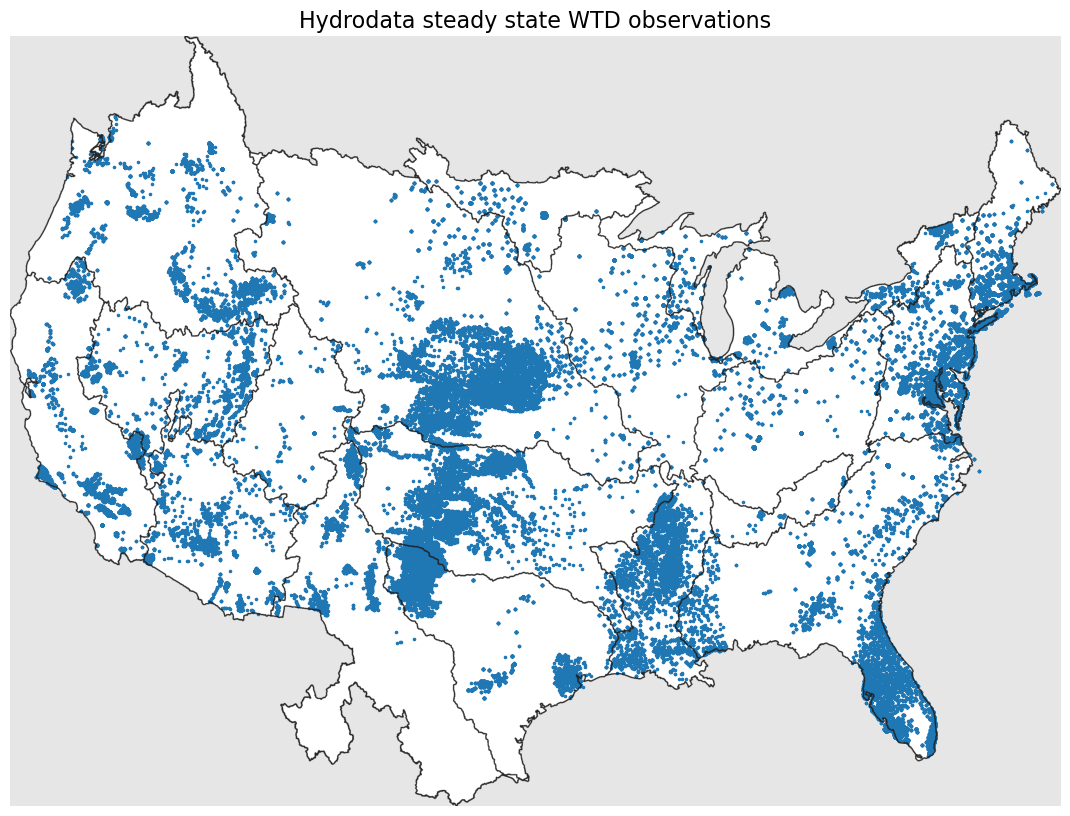

In [36]:
fig, ax = plt.subplots(1,1,figsize=(19,10))
ax.imshow(HUC2_outline, extent=[0, 4442, 0, 3256],zorder=2)
ax.imshow(mask_array[::-1,:], origin='lower', cmap='Greys_r', alpha = 0.1) # CONUS2 outline 
points = ax.scatter(metadata.conus2_x,metadata.conus2_y, s=10,marker='.', zorder=1)#edgecolors='black'
#plt.colorbar(points, label = 'absolute relative bias')
plt.title(f'Hydrodata steady state WTD observations', fontsize = 16)
plt.axis('off')

In [11]:
obs_data

,date,wtd
site_id,,
251241080385301,2003-03-20,-0.076200
251241080385302,2003-03-20,0.271272
251724080341401,2002-10-17,-0.161544
251724080341401,2002-12-16,-0.146304
251724080341401,2003-02-25,-0.021336
...,...,...
485907116294701,2003-07-29,1.804416
485907116294701,2003-08-11,2.063496
485907116294701,2003-08-26,2.331720


In [19]:
pf_flow_matched = np.zeros((len(obs_data),no_days))
pf_flow_matched.shape

(114056, 364)

In [20]:
# make CONUS2 x and y into arrays for the for loop
conusy = np.asarray(metadata['conus2_y'],dtype = 'int')
conusx = np.asarray(metadata['conus2_x'],dtype = 'int')

# Set up arrays 
pf_flow_array = np.zeros((no_days, ny, nx))
pf_flow_matched = pf_flow_matched = np.zeros((len(obs_data)+1,no_days))#np.zeros(obs_data.shape)

### READ STREAMFLOW PFBs ###
#Read in CONUS2 daily  PFBs and save as df in flow_df
for i in range(no_days):
    step = str(int(i+1)).rjust(3, '0')
    print(f'{directory_out}/WTD.2003.daily.{step}.pfb')
    pf_flow_pfb = np.squeeze(read_pfb(f'{directory_out}/WTD.2003.daily.{step}.pfb'))
    pf_flow_array[i,...] = pf_flow_pfb
    print(f'reading PF-CONUS2 output for day {step}')
    for j in range(len(obs_data.index)):
        if conusy[j] < 0:
            pf_flow_matched[j] = 'nan'
            #print('Gage is outside of CONUS2 range')
        else:
            pf_flow_matched[j,i] = pf_flow_array[i, conusy[j], conusx[j]]
            #print('Finding value in CONUS2 grid')

/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/averages/WTD.2003.daily.001.pfb
reading PF-CONUS2 output for day 001
/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/averages/WTD.2003.daily.002.pfb
reading PF-CONUS2 output for day 002
/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/averages/WTD.2003.daily.003.pfb
reading PF-CONUS2 output for day 003
/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/averages/WTD.2003.daily.004.pfb
reading PF-CONUS2 output for day 004
/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/averages/WTD.2003.daily.005.pfb
reading PF-CONUS2 output for day 005
/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/averages/WTD.2003.daily.006.pfb
reading PF-CONUS2 output for day 006
/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/averages/WTD.2003.daily.007.pfb
reading PF-CONUS2 output for day 007
/hydrodata/temp/CONUS2_transfers/CONUS2/spinup_WY2003/averages/WTD.2003.daily.008.pfb
reading PF-CONUS2 output for day 008
/hydrodata/temp/

In [25]:
pf_flow_matched.shape

(114057, 364)

In [21]:
# Organize daily flow matched array with the same index and dates as the obs_data
pf_flow_match_df = pd.DataFrame(pf_flow_matched)
pf_flow_match_df = pf_flow_match_df.set_index(obs_data.index)
column_headers = list(obs_data.columns.values)
pf_flow_match_df.columns = column_headers
pf_flow_match_df.shape

ValueError: Length mismatch: Expected 114057 rows, received array of length 114056

In [7]:
pf_flow_match_df_new = pf_flow_match_df.dropna()
pf_flow_match_df_new

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
290955098562101,0.046598,0.117977,0.220182,0.257405,0.284448,0.303802,0.317972,0.244333,0.002561,0.000000,...,0.066616,0.030094,0.036585,0.041375,0.045606,0.042465,0.046457,0.120872,0.222234,0.0
291136099375801,0.153622,0.322058,0.391806,0.436653,0.473755,0.503918,0.521985,0.256727,0.031601,0.020330,...,1.272928,1.244795,1.222374,1.213699,1.207622,1.197916,1.183117,1.171317,1.164986,0.0
292045099081801,0.179284,0.348520,0.415460,0.462341,0.501713,0.531404,0.538530,0.464910,0.064337,0.043442,...,1.252013,1.228831,1.211517,1.203631,1.199162,1.195820,1.195169,1.194164,1.195079,0.0
292117098524701,0.173391,0.401435,0.502473,0.568874,0.623283,0.662633,0.692886,0.459583,0.015222,0.037403,...,1.056265,0.976283,0.967152,0.980743,0.999757,1.010488,1.015186,1.029755,1.045833,0.0
292505098254002,0.032914,0.038503,0.043972,0.083968,0.311845,0.454438,0.513418,0.406310,0.001405,0.000000,...,1.143994,1.092434,1.073321,1.073828,1.084173,1.094581,1.101546,1.114014,1.128256,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474436096140801,0.109892,0.173431,0.168355,0.097822,0.145832,0.083987,0.140523,0.118270,0.147891,0.174046,...,0.312594,0.301932,0.306290,0.310969,0.314908,0.314318,0.316356,0.319582,0.318147,0.0
474719096163100,0.082452,0.162437,0.173247,0.087892,0.148888,0.106841,0.158594,0.163203,0.185504,0.217269,...,0.880609,0.876330,0.872802,0.870132,0.868071,0.866586,0.865438,0.864634,0.863980,0.0
480034105195401,0.259315,0.322151,0.362726,0.388270,0.401596,0.383001,0.312493,0.049375,0.134051,0.250306,...,1.154418,1.155853,1.157106,1.159074,1.161771,1.164847,1.167729,1.170453,1.172860,0.0


In [8]:
obs_data_new = obs_data[obs_data.index.isin(pf_flow_match_df_new.index)]
obs_data_new

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
290955098562101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-14.825472,-14.819376,-14.828520,-14.871192,-14.892528,-14.935200,-14.938248,-14.907768,-14.892528,-14.901672
291136099375801,45.476160,49.371504,57.290208,55.229760,54.150768,52.776120,52.349400,49.685448,44.906184,43.120056,...,30.967680,30.540960,30.129480,29.708856,29.340048,28.959048,28.648152,28.382976,28.114752,27.852624
292045099081801,43.833288,43.988736,44.052744,44.089320,44.217336,44.189904,44.250864,44.171616,43.988736,43.665648,...,44.284392,44.162472,44.086272,43.958256,43.924728,43.897296,43.888152,43.918632,43.949112,43.943016
292117098524701,11.609832,11.667744,11.707368,11.780520,11.850624,11.868912,11.884152,11.853672,11.618976,11.478768,...,12.874752,12.780264,12.701016,12.594336,12.548616,12.515088,12.512040,12.539472,12.563856,12.621768
292505098254002,-19.808952,-19.699224,-19.607784,-19.568160,-19.641312,-19.598640,-19.559016,-19.644360,-19.891248,-20.083272,...,-20.241768,-20.116800,-20.238720,-20.369784,-20.321016,-20.543520,-20.531328,-20.616672,-20.659344,-20.622768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474436096140801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.663952,2.657856,2.654808,2.660904,2.660904,2.657856,2.673096,2.679192,2.682240,2.685288
474719096163100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.325112,4.331208,4.328160,4.343400,4.340352,4.346448,4.361688,4.367784,4.370832,4.376928
480034105195401,13.371576,13.368528,13.356336,13.362432,13.359384,13.362432,13.356336,13.365480,13.350240,13.344144,...,13.392912,13.389864,13.380720,13.399008,13.380720,13.386816,13.402056,13.411200,13.414248,13.414248


In [9]:
metadata_new = metadata[metadata.index.isin(pf_flow_match_df_new.index)]
metadata_new

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,conus1_x,conus1_y,conus2_x,conus2_y,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
290955098562101,groundwater well,USGS,TD-68-49-813 (Devine),290955098562101,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,29.165778,-98.939411,TX,12110109,...,C,3200.00,3200.0,L,8653-00270,NaN,NaN,2019,485,327
291136099375801,groundwater well,USGS,YP-69-51-606 (E. Uvalde 3),291136099375801,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,29.193573,-99.632830,TX,12110106,...,C,1400.00,1400.0,D,8653-BQ101,NaN,NaN,1951,490,338
292045099081801,groundwater well,USGS,TD-69-47-306,292045099081801,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,29.346068,-99.138647,TX,12110107,...,C,1600.00,1600.0,S,8653-00270,NaN,NaN,2000,506,362
292117098524701,groundwater well,USGS,TD-68-41-301,292117098524701,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,29.354957,-98.880028,TX,12100302,...,C,710.00,710.0,S,8653-00270,NaN,NaN,2025,506,331
292505098254002,groundwater well,USGS,AY-68-37-522 (San Antonio Transect A-2),292505098254002,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,29.418289,-98.428071,TX,12100301,...,C,1075.00,1075.0,O,8653-00270,NaN,NaN,2069,512,363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474436096140801,groundwater well,USGS,E03-R 149N44W12BADA 01 000065...,474436096140801,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,47.743294,-96.235442,MN,9020303,...,U,69.00,76.0,D,MN-18000,1867.0,1575.0,2263,2501,340
474719096163100,groundwater well,USGS,E05-R 150N44W27ABBAA 01 L058,474719096163100,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,47.788900,-96.276125,MN,9020303,...,U,18.06,22.0,S,MN-18000,1864.0,1580.0,2260,2506,56
480034105195401,groundwater well,USGS,26N49E13ACAB01 Wolf Point,480034105195401,https://waterservices.usgs.gov/nwis/site/?form...,2023-03-08,48.009364,-105.331008,MT,10060002,...,U,180.00,180.0,S,MT076,1185.0,1641.0,1610,2561,365


In [10]:
# save matched daily average flow and metadata as csv's
pf_flow_match_df_new.to_csv(f'{organized_dir}/PFCONUS2_Daily_matched_WTD_m_{water_year}.csv', sep = ",")
obs_data_new.to_csv(f'{organized_dir}/USGS_Daily_matched_WTD_m_{water_year}.csv', sep = ",")
metadata_new.to_csv(f'{organized_dir}/USGS_metadata_matched_WTD_m_{water_year}.csv', sep = ",")

In [ ]:
# # Calculate Annual Average Flow for PFCLM and save
# pf_flow_avg = np.mean(pf_flow_array, axis = 0) #monthly average 
# pf_flow_avg.shape
# np.savetxt(f'{organized_dir}/PFCONUS2_Annual_Avg_Flow_cms_WY2003.csv', pf_flow_avg, delimiter=",")

In [ ]:
pf_flow_array.shape

In [ ]:
pf_flow_match.shape